# TPT pipeline with ERA5 and S2S

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [3]:
%load_ext autoreload

In [4]:
%aimport xr_utils
%aimport feature_template
%aimport feature_stratosphere
%aimport tpt_utils

In [5]:
import matplotlib
from matplotlib import ticker
matplotlib.rcParams.update({"font.size": 15})
matplotlib.rcParams["font.family"] = 'monospace'
%matplotlib inline

# Set up experiment

In [6]:
create_eofs_flag =                   0
featurize_flag =                     0
recombine_features_flag =            1

In [46]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "e5": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-08-23"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-23"),
                #"filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-23",),
                #"filename": "era5_features_tpt.nc",
            }),
            "color": "dodgerblue",
        }),
        "s2": dict({
            "traj": dict({
                "dir": join(topic_dir, "s2s_data", "raw_data", "2022-08-20"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "s2s_data", "stats", "2022-08-25"),
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "s2s_data", "features_all", "2022-08-25"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "s2s_data", "features_tpt", "2022-08-25",),
                "filename": "s2s_features_tpt.nc",
            }),
            "color": "red",
        })    
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-23")
    })
})
dispdict = dict({
    "e5": dict({
        "color": "dodgerblue",
        "abbrv": "ERA5",
    }),
    "s2": dict({
        "color": "red",
        "abbrv": "S2S",
    })
})

In [8]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

# Define EOFs

Compute from data between October and March

In [ ]:
trajdir = filedict["data"]["e5"]["traj"]["dir"]
file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
ds_eofs, ds_monclim = xr_utils.compute_eofs(file_list, "e5", months_of_interest = [10, 11, 12, 1, 2, 3])

Save them to file

In [ ]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
eofdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_eofs.close()
ds_monclim.to_netcdf(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
ds_monclim.close()

Reload and plot them 

In [9]:
statsdir = filedict["data"]["e5"]["stats"]["dir"]
ds_eofs = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["eof_filename"]))
ds_monclim = xr.open_dataset(join(statsdir, filedict["data"]["e5"]["stats"]["monthly_climatology_filename"]))
ds_eofs.close()
ds_monclim.close()

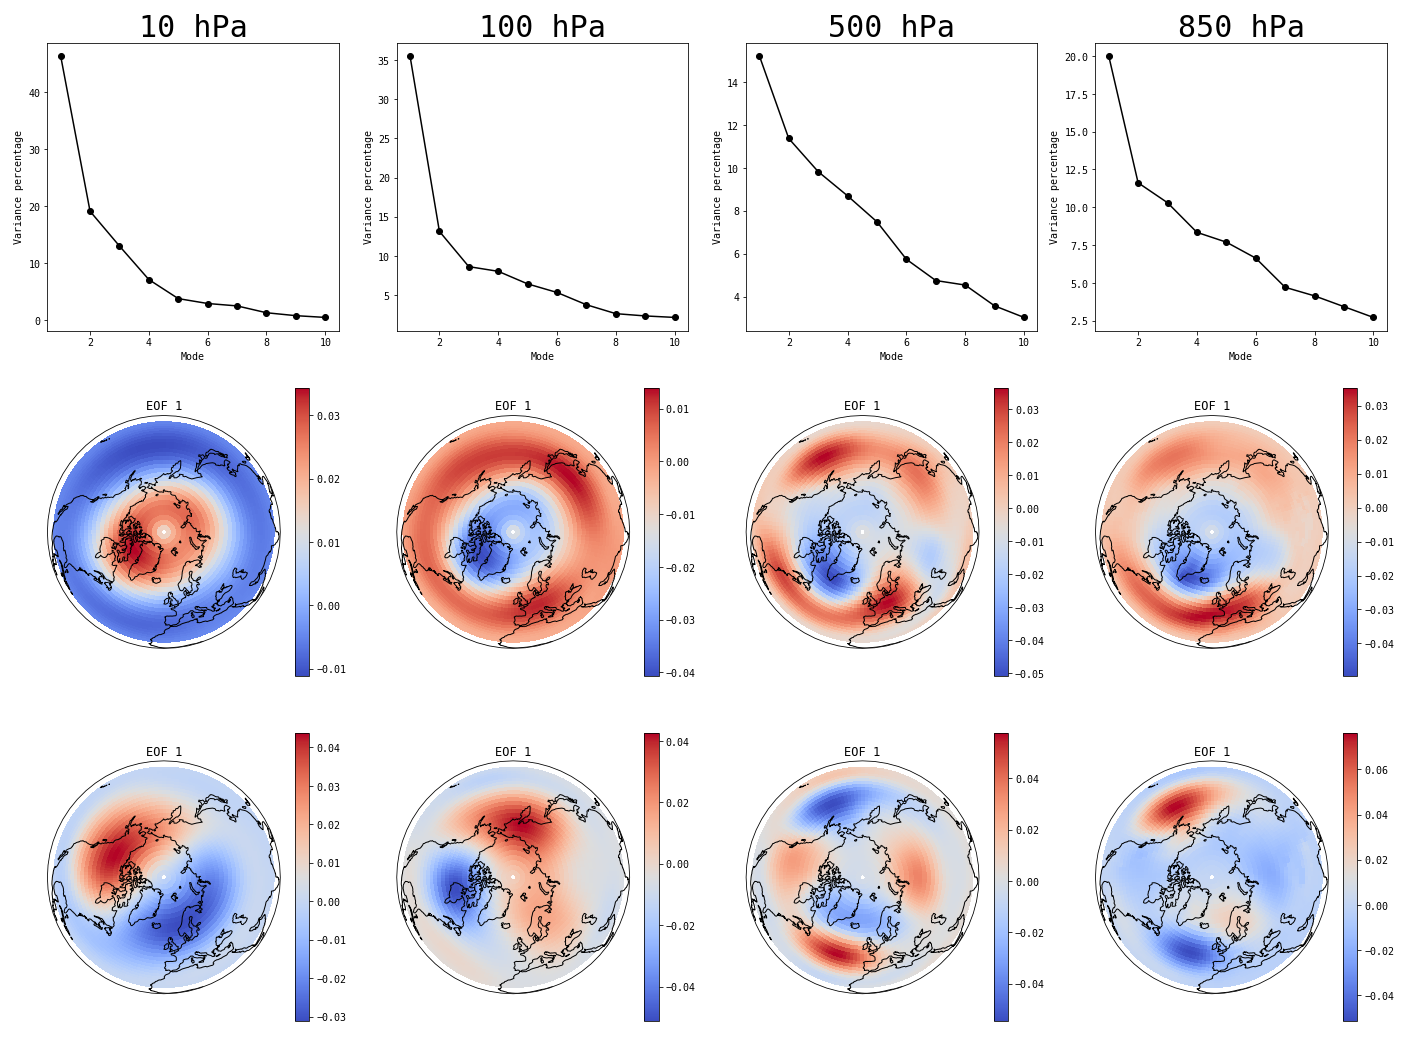

In [10]:
fig = matplotlib.pyplot.figure(figsize=(24,18))
eofs, variance_fraction = ds_eofs["eofs"], ds_eofs["variance_fraction"]
for i_lev in range(4):
    # Plot singular value spectrum
    ax = fig.add_subplot(3,4,i_lev+1)
    vf = variance_fraction.isel(level=i_lev)
    ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
    ax.set_xlabel("Mode")
    ax.set_ylabel("Variance percentage")
    ax.set_title(f"{variance_fraction.level.data[i_lev]} hPa", font={"size": 30})
    # Plot EOF 1
    ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=1).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    # Plot EOF 2
    ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
    xr_utils.display_pole_field(eofs.sel(mode=2).isel(level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    

## Read database and compute features. 

In [11]:
reload(feature_stratosphere)
reload(xr_utils)

<module 'xr_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/xr_utils.py'>

In [12]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

Specify any feature definitions

In [13]:
featdef = {"ds_eofs": ds_eofs, "ds_monclim": ds_monclim}

In [ ]:
obs2compute = [
    "time_observable", "ubar_observable", "pc_observable", 
    "temperature_observable", "heatflux_observable",
    "qbo_observable",
]
for src in ["e5","s2"]:
    obs_dict = dict({obsname: [] for obsname in obs2compute})
    input_dir = filedict["data"][src]["traj"]["dir"]
    input_file_list = [f for f in os.listdir(input_dir) if f.endswith(".nc")]
    output_dir = filedict["data"][src]["feat_all"]["dir"]
    feat_strat.compute_all_features(
        src, input_dir, input_file_list, output_dir, 
        featdef, obs2compute=obs2compute
    )

Reload the TPT features as a dictionary. We don't yet put them in a single dataset in order to avoid dimension conflicts. 

In [14]:
feat_all = dict()
for src in ["s2","e5"]:
    feat_all[src] = feat_strat.assemble_all_features(
        src,
        filedict["data"][src]["feat_all"]["dir"]
        )

Plot some climatological envelopes, as well as some hindcast ensembles from the same year 

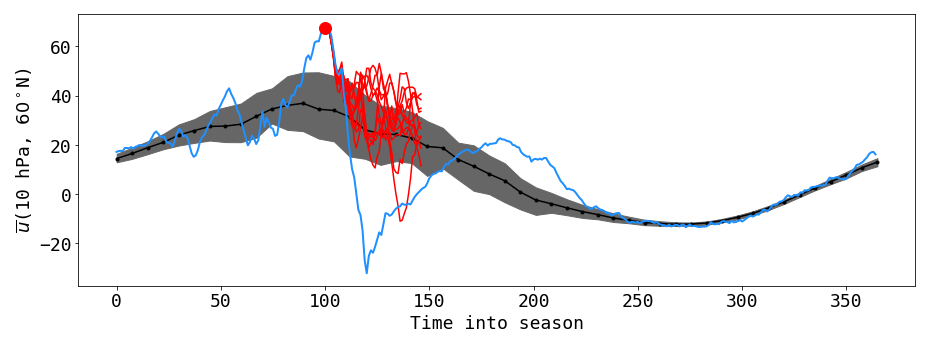

In [15]:
fig,ax = plt.subplots(figsize=(15,5))

year2plot = 2008
obs_group = "ubar_observable"
obs_name = "ubar_10_60"
obs_label = "$\overline{u}$(10 hPa, $60^\circ$N)"
t_init_target = 100.0 # How many days into the season
i_t_init = int(t_init_target / 3.5)

cond_e5 = 1*(feat_all["e5"]["time_observable"].sel(feature="year_szn_start") == year2plot)
cond_s2 = 1*(feat_all["s2"]["time_observable"].isel(t_sim=0).sel(feature="year_szn_start") == year2plot)

tpt_utils.plot_field_1d(
    feat_all["e5"][obs_group].sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(), 
    np.ones(feat_all["e5"][obs_group].t_sim.size), 
    feat_all["e5"]["time_observable"].sel(feature="t_szn").isel(t_init=0,member=0).to_numpy(),
    feat_name="Time into season", field_name=obs_label,
    fig=fig, ax=ax, nbins=50
)
for i_mem in range(feat_all["s2"]["time_observable"].member.size):
    x_ens, = feat_all["s2"]["time_observable"].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature="t_szn").to_numpy(),
    y_ens, = feat_all["s2"][obs_group].where(cond_s2,drop=True).isel(t_init=i_t_init,member=i_mem).sel(feature=obs_name).to_numpy(),
    ax.plot(x_ens, y_ens, color='red')
    if i_mem == 0: ax.scatter(x_ens[0], y_ens[0], color='red', marker='o', zorder=10, s=144)
    
ax.plot(
    feat_all["e5"]["time_observable"].where(cond_e5,drop=True).sel(feature="t_szn").isel(t_init=0,member=0).to_numpy(),
    feat_all["e5"][obs_group].where(cond_e5,drop=True).sel(feature=obs_name).isel(t_init=0,member=0).to_numpy(),
    color='dodgerblue', linewidth=2
)


Plot some two-dimensional densities, at multiple time slices throughout the season.

In [16]:
reload(tpt_utils)

<module 'tpt_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/../../tpt_utils.py'>

# Assemble features for TPT.

In [17]:
reload(feature_stratosphere)
reload(xr_utils)

<module 'xr_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/xr_utils.py'>

In [18]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

Assemble and save the features with time delays

In [ ]:
for src in ["s2","e5"]:
    feat_strat.assemble_tpt_features(feat_all[src], filedict["data"][src]["feat_tpt"]["dir"])

Reload them

In [19]:
feat_tpt = dict()
for src in ["s2","e5"]:
    feat_tpt[src] = xr.open_dataarray(join(filedict["data"][src]["feat_tpt"]["dir"], "features_tpt.nc"))

# Plot some densities to get a feel for the data

Two-dimensional histograms of various observables

In [20]:
reload(tpt_utils)

<module 'tpt_utils' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/../../tpt_utils.py'>

In [21]:
src = "s2"
feats2plot = ["ubar_10_60_delay0","vT_100_1_runavg10"]
cond = 1*(
    (feat_tpt[src].sel(feature="t_szn") > 10) * 
    (feat_tpt[src].sel(feature="t_szn") < 50)
)
feat_names = ["U1060","vT 10-day mean"]
data_cond = feat_tpt[src].where(cond)
data_cond = data_cond.sel(feature=feats2plot,drop=True)
data_cond = data_cond.stack(snapshot=("t_init","member","t_sim"))

vmin = 1.0


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='U1060', ylabel='vT 10-day mean'>)

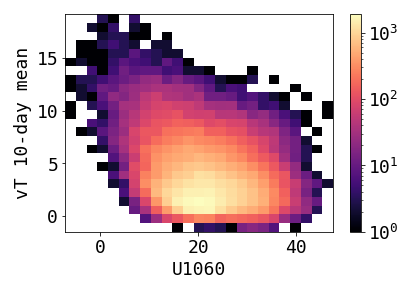

In [22]:
fig,ax = plt.subplots()
tpt_utils.plot_field_2d(
    np.ones(data_cond.snapshot.size), 
    np.ones(data_cond.snapshot.size),
    np.array([
        data_cond.sel(feature=feats2plot[0]).to_numpy().flatten(), 
        data_cond.sel(feature=feats2plot[1]).to_numpy().flatten()
    ]).T,
    feat_names = feat_names,
    fig=fig, ax=ax, shp=[25,25],
    stat_name="weightsum", 
    cmap=plt.cm.magma, logscale=True
)

# Return time estimates: three methods 

## Method 1: extreme value theory

In [23]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()
t_thresh = np.array([0, 180]) # Days since October 1

In [100]:
extval_stats = dict()
for src in ["e5","s2"]:
    cond = (
        (feat_tpt[src].sel(feature="t_szn") > t_thresh[0]) * 
        (feat_tpt[src].sel(feature="t_szn") < t_thresh[1]) 
    )
    field = (
        feat_tpt[src]
        .where(cond)
        .sel(feature="ubar_10_60_delay0")
        .to_numpy().reshape(-1,1)
    ).copy()
    weights = np.ones_like(field)
    year_szn_start = (
        feat_tpt[src]
        .where(cond)
        .sel(feature="year_szn_start",drop=True)
        .to_numpy()
        .reshape(-1,1) #.astype(int)
    ).copy()
    bounds = np.array([[np.nanmin(year_szn_start)-0.5], [np.nanmax(year_szn_start)+0.5]])
    shp = (np.round(bounds[1] - bounds[0])).astype(int)
    ubar_yearly_stats, edges, centers = tpt_utils.project_field(  
        field, weights, year_szn_start, shp=shp, bounds=bounds
    )
    # Compute return period for a list of block minima
    umin = ubar_yearly_stats['min'].flatten()
    umax = ubar_yearly_stats['max'].flatten()
    order = np.argsort(-umin)
    rank = np.argsort(order)
    cdf_emp = rank / len(umin)
    rate_emp = 1 - cdf_emp
    # Adjust the lower-bound return time by dividing by the total number of ensemble members in a given year
    rate_lower = rate_emp 
    if src == "s2":
        num_init_per_szn = ubar_yearly_stats["weightsum"].flatten() / (feat_tpt[src].member.size * feat_tpt[src].t_sim.size)
        rate_lower *= 1.0 / num_init_per_szn
    # Save the extreme value statistics
    extval_stats[src] = dict({
        "umin": umin, "umax": umax, "rate_lower": rate_lower, "fall_years": centers[0].astype(int)
    })

In [101]:
fyidx = dict({
    "e5": np.where(np.in1d(extval_stats["e5"]["fall_years"], extval_stats["s2"]["fall_years"])),
    "s2": np.where(np.in1d(extval_stats["s2"]["fall_years"], extval_stats["e5"]["fall_years"]))
})
fy_common = extval_stats["e5"]["fall_years"][fyidx["e5"]]

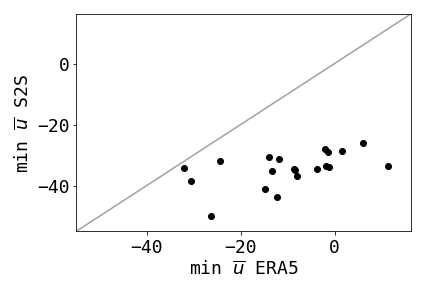

In [116]:
fig,ax = plt.subplots()

# Second plot: minimum S2S vs minimum E5
xlim = [0,0]
xdata = extval_stats["e5"]["umin"][fyidx["e5"]]
ydata = extval_stats["s2"]["umin"][fyidx["s2"]]
xlim = [min(xdata.min(), ydata.min()) - 5, max(xdata.max(), ydata.max()) + 5]
h = ax.scatter(xdata, ydata, color='black', label="min $\overline{u}$")
ax.set_xlabel("min $\overline{u}$ ERA5")
ax.set_ylabel("min $\overline{u}$ S2S")
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.plot(xlim, xlim, color='gray', zorder=-1, alpha=0.75)


Plot the return level vs. return time for minimum U1060. Is there some natural way to do this just using A and B definitions? 

## Method 2: count paths from each initialization

In [55]:
# Match initialization dates in S2S with actual dates in ERA5
e5idx = np.argmin(
    np.abs(
        np.subtract.outer(
            feat_all["s2"]["time_observable"]["t_init"].astype("datetime64[ns]").to_numpy().flatten(),
            feat_all["e5"]["time_observable"].sel(feature="t_dt64").astype("datetime64[ns]").to_numpy().flatten()
        )
    ), axis=1
)
t_szn_e5idx = feat_all["e5"]["time_observable"].sel(feature="t_szn").isel(t_sim=e5idx).to_numpy().flatten()

### Loop over many values of A and B

In [121]:
rate_hybrid = xr.DataArray(
    coords = {"u_thresh": np.arange(-36, 1, 4), "e5_weight": np.array([0.0, 0.25, 0.5, 0.75, 1.0]), "bound": ["lower","upper"]},
    dims = ["u_thresh","e5_weight","bound"]
)
rate_e5 = xr.DataArray(
    coords = {"u_thresh": rate_hybrid["u_thresh"],},
    dims = ["u_thresh"],
)
for uth in rate_hybrid["u_thresh"].data:
    print(f"---------- Starting u_thresh {uth} --------------")
    feat_strat.set_ab_boundaries(t_thresh[0], t_thresh[1], uth)
    ab_tag = dict()
    cej = dict() # Hitting times (Cotton-eye Joe)
    comm_emp = dict() # Empirical committor: to B in forward time, from A in backward time
    rate_emp = dict() # Empirical rate estimate 
    for src in ["e5","s2"]:
        ab_tag[src] = feat_strat.ab_test(feat_tpt[src])
        mode = "timechunks" if src == "e5" else "timesteps" # This determines the computation pattern for iterating through the dataset
        cej[src] = feat_strat.cotton_eye_joe(feat_tpt[src],ab_tag[src],mode=mode)
        comm_emp[src] = feat_strat.estimate_empirical_committor(cej[src])
        rate_emp[src] = feat_strat.estimate_rate(cej[src], comm_emp[src])
        # Save each item
        #ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
        #cej[src].to_netcdf(join(filedict["results"]["dir"], f"cej_{src}.nc"))    
        #comm_emp[src].to_netcdf(join(filedict["results"]["dir"], f"comm_emp_{src}.nc"))
        #rate_emp[src].to_netcdf(join(filedict["results"]["dir"], f"rate_emp_{src}.nc"))

    # To ge the ERA5 rate, use all the years
    rate_e5.loc[dict(u_thresh=uth)] = feat_strat.estimate_rate(cej["e5"], comm_emp["e5"]).to_numpy().item() * 365.25
    # To do the bounds, attach the past of reaanalysis to each initialization date 
    comm_bwd_e5 = comm_emp["e5"].isel(t_sim=e5idx,t_init=0,member=0).sel(sense="since").to_numpy()
    comm_fwd_e5 = comm_emp["e5"].isel(t_sim=e5idx,t_init=0,member=0).sel(sense="until").to_numpy()
    comm_fwd_s2_lower = 1.0*(comm_emp["s2"].sel(sense="until").isel(t_sim=0) == 1).mean(dim="member").to_numpy()
    comm_fwd_s2_upper = 1.0*(comm_emp["s2"].sel(sense="until").isel(t_sim=0) != 0).mean(dim="member").to_numpy()

    # Find the branches beginning outside of A and B 
    domain_idx, = np.where(ab_tag["e5"].isel(t_sim=e5idx,t_init=0,member=0) == feat_strat.ab_code["D"])

    # Get a rate estimate for each individual branch point, to be linearly combined later
    # Assign weights to the real world and to hindcasts
    for e5_weight in rate_hybrid["e5_weight"].data: 
        rate_hybrid.loc[dict(u_thresh=uth,e5_weight=e5_weight,bound="lower")] = (
            comm_bwd_e5 * (e5_weight * comm_fwd_e5 + (1-e5_weight) * comm_fwd_s2_lower)
        )[domain_idx].mean()
        rate_hybrid.loc[dict(u_thresh=uth,e5_weight=e5_weight,bound="upper")] = (
            comm_bwd_e5 * (e5_weight * comm_fwd_e5 + (1-e5_weight) * comm_fwd_s2_upper)
        )[domain_idx].mean()

---------- Starting u_thresh -36 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -32 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -28 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -24 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -20 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -16 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 out of 47
Backward pass: through time 0 out of 47
---------- Starting u_thresh -12 --------------
t_sim.shape = (22280,)
Forward pass: through time 0 

Text(0.5, 1.0, 'TPT rate estimate')

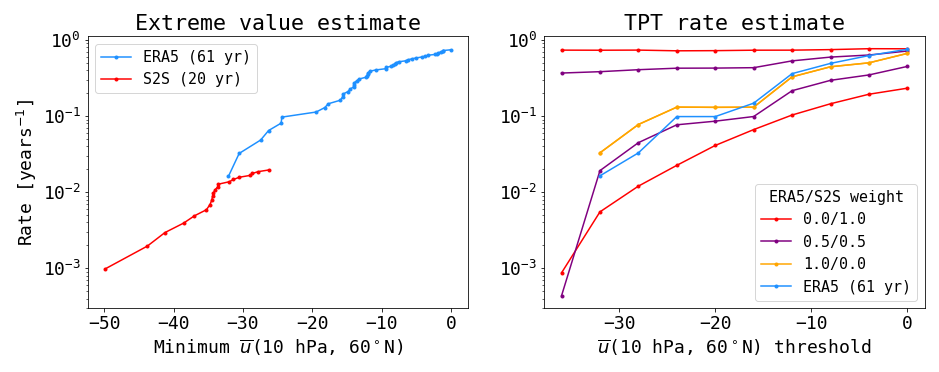

In [141]:
fig,axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
axes[1].yaxis.set_tick_params(labelbottom=True)

# First plot: extreme values
ax = axes[0]
labels = {"e5": "ERA5 (61 yr)", "s2": "S2S (20 yr)"}
handles = []
for src in ["e5","s2"]:
    idx, = np.where(extval_stats[src]["umin"] < 0)
    order = np.argsort(extval_stats[src]["umin"][idx])
    h, = ax.plot(
        extval_stats[src]["umin"][idx][order], extval_stats[src]["rate_lower"][idx][order], 
        color=dispdict[src]["color"],
        marker='.', label=labels[src]
    ) 
    handles += [h]
ax.legend(handles=handles, fontsize="small")
ax.set_xlabel("Minimum $\overline{u}$(10 hPa, 60$^\circ$N)")
ax.set_ylabel("Rate [years$^{-1}$]")
ax.set_yscale("log")
ax.set_title("Extreme value estimate")

# Second plot: rates
ax = axes[1]
rate_hybrid = rate_hybrid.where(rate_hybrid > 0)
colors = ["red", "purple", "orange"]
labels = [""]
i_weights_2plot = [0, 2, 4]
handles = []
for i in range(len(i_weights_2plot)):
    e5_weight = rate_hybrid["e5_weight"][i_weights_2plot[i]]
    ax.plot(rate_hybrid["u_thresh"], rate_hybrid.sel(e5_weight=e5_weight).sel(bound="lower"), color=colors[i], marker='.')
    h, = ax.plot(
        rate_hybrid["u_thresh"], rate_hybrid.sel(e5_weight=e5_weight).sel(bound="upper"), 
        color=colors[i], marker='.', label=r"%.1f/%.1f"%(e5_weight,1-e5_weight)
    )
    handles += [h]
# Additionally plot ERA5 only
h, = ax.plot(rate_e5["u_thresh"], rate_e5.where(rate_e5>0), color="dodgerblue", marker='.', label="ERA5 (61 yr)")
ax.plot
handles += [h]
ax.set_yscale("log")
ax.set_xlabel("$\overline{u}$(10 hPa, 60$^\circ$N) threshold")
ax.legend(handles=handles, title="ERA5/S2S weight", fontsize="small", title_fontsize="small")
ax.set_title("TPT rate estimate")

## Method 3: probably bogus

#### A weight must be assigned to each hindcast trajectory, depending on how many ensembles were initialized before it during the season. 

In [ ]:
# Assign a rank (first hindcast of the season has rank 1, second has rank 2, etc.) as if the world were re-initialized every season start
rank_da = xr.DataArray(
    coords = {"t_init": feat_tpt["s2"]["t_init"],},
    dims = ["t_init",],
)
num_init = feat_tpt["s2"]["t_init"].size
t_init = rank_da["t_init"].astype("datetime64[ns]").to_numpy().flatten()
fall_year_init = feat_all["s2"]["time_observable"].sel(feature="year_szn_start").isel(t_sim=0,member=0).to_numpy().flatten()
t_szn_init = feat_all["s2"]["time_observable"].sel(feature="t_szn").isel(t_sim=0,member=0).to_numpy().flatten()
# Remove the first year because that full season is not accounted for
all_fall_years = np.sort(np.unique(fall_year_init))[1:]
for i_fy,fy in enumerate(all_fall_years):
    fyidx, = np.where((fall_year_init == fy) * (t_szn_init >= t_thresh[0]) * (t_szn_init < t_thresh[1]))
    order = np.argsort(t_init[fyidx])
    rank_da[dict(t_init=fyidx)] = np.argsort(order) + 1


## Plot some pictures of the committor 

In [ ]:
fig,axes = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
years2plot = np.arange(1984,1992)
tidx, = np.where(np.in1d(feat_tpt["ra"].sel(feature="year_szn_start").to_numpy(), years2plot))
isel = dict(ensemble=0,member=0, t_sim=tidx)
h_ubar, = xr.plot.plot(
    feat_tpt["ra"].isel(isel,drop=True).sel(feature="vT_100_1_runavg15"),
    color="black",ax=axes[0],label="$u1060$",x="t_sim"
)
handles = []
for set_code in ["A","B"]:
    color = "dodgerblue" if set_code == "A" else "red"
    starts, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == 1)
    ends, = np.where(np.diff(1*(ab_tag["ra"].isel(isel,drop=True).data.flatten()==feat_strat.ab_code[set_code])) == -1)
    if starts[0] > ends[0]: 
        ends = ends[1:]
    if starts[-1] > ends[-1]:
        starts = starts[:-1]
    for i in range(len(starts)):
        axes[0].axvspan(
            feat_tpt["ra"]["t_sim"][tidx[starts[i]]], feat_tpt["ra"]["t_sim"][tidx[ends[i]]], 
            color=color, alpha=0.5, zorder=-1
        )
    h_hittime, = xr.plot.plot(
        cej["ra"].isel(isel,drop=True).sel(state=set_code, sense="until", drop=True),
        ax=axes[1], label=r"$\tau_%s^+$"%(set_code), color=color)
    handles += [h_hittime]

axes[0].axhline(y=feat_strat.tpt_bndy["ubar_10_60_thresh"], color='black')
axes[0].legend(handles=[h_ubar], prop={"size": 18})
axes[1].legend(handles=handles, prop={"size": 18})


In [ ]:
feat = "pc_10_3" # The independent variable
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0]+50) 
)
# Committor
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
# Next hitting time
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()
tpt_utils.plot_field_1d(
    qp, np.ones(qp.size), 
    feat_tpt["ra"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1], feat_name=feat, field_name="Committor to B"
)
tpt_utils.plot_field_1d(
    -Tb, qp, 
    feat_tpt["ra"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)


In [ ]:
# Choose the two features
feat0,feat1 = "ubar_10_60_delay0","ubar_10_60_delay10"
# Select the first ensemble and member (trivial for reanalysis: there's only one realization)
sel = dict(ensemble=0,member=0) 
# Take a slice of the season, between two times
cond = (
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") > feat_strat.tpt_bndy["t_thresh"][0]) * 
    (feat_tpt["ra"].sel(sel,drop=True).sel(feature="t_szn") < feat_strat.tpt_bndy["t_thresh"][0] + 50) 
)
# Call the committor qp (q-plus) and the hitting time to B Tb
qp = comm_emp["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = cej["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
# First plot: committor
tpt_utils.plot_field_2d(
    qp, # function values
    np.ones(feat_tpt["ra"]["t_sim"].size), # weights
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True), # Feature space
    feat_names = [feat0,feat1],  # axis labels
    shp=[20,20], # shape of the 2D grid controls how pixellated the image is
    fig=fig, ax=axes[0], field_name=r"$q_B^+$" #other display parameters
)
# Second plot: hitting time (negative, so it increases towards B)
tpt_utils.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[1], field_name=r"$-\tau_B^+$"
)
# Third plot: hitting time conditioned on hitting B first
tpt_utils.plot_field_2d(
    -Tb*qp,
    qp,
    feat_tpt["ra"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[20,20], fig=fig, ax=axes[2], field_name=r"$-\eta_B^+$"
)


# Estimate the rate from ERA5. 

And include error bars. This time, we will plot return period as a function of return level.